## Import Python Module to Create/Upload New Data Instances
### (Persona: Data Engineer)

Use metaflow-based data model

In [1]:
import s3fs
import os
import json
from opal.weave.create_index import create_index_from_s3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
s3 = s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']})

# What data do I have?

### Create an index of my data store using Weave.

<img src="resources/weave to minio.drawio.png">

In [3]:
index = create_index_from_s3('basket-data')
index

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
0,cb33dc3afbfe11edb4a40242ac120005,05/26/2023 19:52:06,[],NASA_ARINC429_DTS,,basket-data/NASA_ARINC429_DTS/cb33dc3afbfe11ed...,s3
1,d611a2b8fbfe11edb4a40242ac120005,05/26/2023 19:52:25,[],NASA_MILSTD1553_DTS,,basket-data/NASA_MILSTD1553_DTS/d611a2b8fbfe11...,s3
2,00762bacfbf311ed9ee60242ac120005,05/26/2023 18:27:42,[],ch10,652200101201352,basket-data/ch10/00762bacfbf311ed9ee60242ac120005,s3
3,018e74aefbf311ed9ee60242ac120005,05/26/2023 18:27:45,[],ch10,652200101201529,basket-data/ch10/018e74aefbf311ed9ee60242ac120005,s3
4,01adda32fbf411ed9ee60242ac120005,05/26/2023 18:34:55,[],ch10,652200104061524,basket-data/ch10/01adda32fbf411ed9ee60242ac120005,s3
...,...,...,...,...,...,...,...
1717,fe114d84fc0011edb1fd0242ac120005,05/26/2023 20:07:51,"[ebdd1172fbf911ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200101281020,basket-data/ch10_translated_MILSTD1553/fe114d8...,s3
1718,fec63916fbff11edb1fd0242ac120005,05/26/2023 20:00:42,"[804128aefbf911ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200104101843,basket-data/ch10_translated_MILSTD1553/fec6391...,s3
1719,fece7e24fbfe11edb1fd0242ac120005,05/26/2023 19:53:33,"[08537128fbfc11ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200101130002,basket-data/ch10_translated_MILSTD1553/fece7e2...,s3
1720,ff6baf4efc0011edb1fd0242ac120005,05/26/2023 20:07:53,"[ec0c0f60fbfc11ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200104010905,basket-data/ch10_translated_MILSTD1553/ff6baf4...,s3


In [4]:
index.basket_type.value_counts()

ch10                          560
ch10_parsed                   560
ch10_translated_MILSTD1553    560
ch10_translated_ARINC429       40
NASA_ARINC429_DTS               1
NASA_MILSTD1553_DTS             1
Name: basket_type, dtype: int64

# Where did my data come from?

### Provenance tracking example using Metaflow and TIP.

In [5]:
small_index = create_index_from_s3('provenance-demo')
small_index

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
0,540f6386e51f11edb7020242ac12000a,04/27/2023 17:17:03,[],NASA_ARINC429_DTS,,provenance-demo/NASA_ARINC429_DTS/540f6386e51f...,s3
1,5ad74a12e51f11edb7020242ac12000a,04/27/2023 17:17:14,[],NASA_MILSTD1553_DTS,,provenance-demo/NASA_MILSTD1553_DTS/5ad74a12e5...,s3
2,224076e4e52211edb7020242ac12000a,04/27/2023 17:37:08,[],ch10,tail_35_pilot_slider_1,provenance-demo/ch10/224076e4e52211edb7020242a...,s3


In [6]:
!python /home/jovyan/opal/data-engineering-resources/NASA_ch10_flows/parse_nasa_ch10s_flow.py run --bucket_name provenance-demo --n 1

Metaflow 2.7.23 executing NASAch10ParseFlow for user:jovyan
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-05-26 20:44:37.882 Workflow starting (run-id 1685133877370598):
2023-05-26 20:44:37.899 [1685133877370598/start/1 (pid 9096)] Task is starting.
2023-05-26 20:44:41.394 [1685133877370598/start/1 (pid 9096)] Task finished successfully.
2023-05-26 20:44:41.440 [1685133877370598/parse_ch10s/2 (pid 9136)] Task is starting.
2023-05-26 20:44:43.010 [1685133877370598/parse_ch10s/2 (pid 9136)] 1/1: provenance-demo/ch10/224076e4e52211edb7020242ac12000a
2023-05-26 20:44:43.175 [1685133877370598/parse_ch10s/2 (pid 9136)] GetTerminalSize(): Call to ioctl failed
2023-05-26 20:44:46.331 [1685133877370598/parse_ch10s/2 (pid 9136)] CLIGroup(): Failed to get terminal size
2023-05-26 20:44:46.331 [1685133877370598/parse_ch10s/2 (pid 9136)] basket successfully parsed and uploaded: provenance-demo/ch10_parsed/264432c6fc0611edafe00242ac120005
2023-05-26 20

In [7]:
small_index = create_index_from_s3('provenance-demo')
small_index

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
0,540f6386e51f11edb7020242ac12000a,04/27/2023 17:17:03,[],NASA_ARINC429_DTS,,provenance-demo/NASA_ARINC429_DTS/540f6386e51f...,s3
1,5ad74a12e51f11edb7020242ac12000a,04/27/2023 17:17:14,[],NASA_MILSTD1553_DTS,,provenance-demo/NASA_MILSTD1553_DTS/5ad74a12e5...,s3
2,224076e4e52211edb7020242ac12000a,04/27/2023 17:37:08,[],ch10,tail_35_pilot_slider_1,provenance-demo/ch10/224076e4e52211edb7020242a...,s3
3,264432c6fc0611edafe00242ac120005,05/26/2023 20:44:46,[224076e4e52211edb7020242ac12000a],ch10_parsed,tail_35_pilot_slider_1,provenance-demo/ch10_parsed/264432c6fc0611edaf...,s3


In [8]:
!python /home/jovyan/opal/data-engineering-resources/NASA_ch10_flows/translate_nasa_ch10s_flow.py run --bucket_name provenance-demo --n 1
!python /home/jovyan/opal/data-engineering-resources/NASA_ch10_flows/translate_nasa_ch10s_flow.py run --bucket_name provenance-demo --data_type ARINC429 --n 1

Metaflow 2.7.23 executing NASAch10TranslateFlow for user:jovyan
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-05-26 20:45:08.351 Workflow starting (run-id 1685133908162493):
2023-05-26 20:45:08.364 [1685133908162493/start/1 (pid 9275)] Task is starting.
2023-05-26 20:45:11.420 [1685133908162493/start/1 (pid 9275)] Task finished successfully.
2023-05-26 20:45:11.503 [1685133908162493/get_dts_file/2 (pid 9328)] Task is starting.
2023-05-26 20:45:14.700 [1685133908162493/get_dts_file/2 (pid 9328)] Task finished successfully.
2023-05-26 20:45:14.774 [1685133908162493/translate_parsed/3 (pid 9369)] Task is starting.
2023-05-26 20:45:16.275 [1685133908162493/translate_parsed/3 (pid 9369)] -- translating 1 of 1: provenance-demo/ch10_parsed/264432c6fc0611edafe00242ac120005
2023-05-26 20:45:16.379 [1685133908162493/translate_parsed/3 (pid 9369)] GetTerminalSize(): Call to ioctl failed
2023-05-26 20:45:17.825 [1685133908162493/translate_parsed/3 (p

In [9]:
small_index = create_index_from_s3('provenance-demo')
small_index

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
0,540f6386e51f11edb7020242ac12000a,04/27/2023 17:17:03,[],NASA_ARINC429_DTS,,provenance-demo/NASA_ARINC429_DTS/540f6386e51f...,s3
1,5ad74a12e51f11edb7020242ac12000a,04/27/2023 17:17:14,[],NASA_MILSTD1553_DTS,,provenance-demo/NASA_MILSTD1553_DTS/5ad74a12e5...,s3
2,224076e4e52211edb7020242ac12000a,04/27/2023 17:37:08,[],ch10,tail_35_pilot_slider_1,provenance-demo/ch10/224076e4e52211edb7020242a...,s3
3,264432c6fc0611edafe00242ac120005,05/26/2023 20:44:46,[224076e4e52211edb7020242ac12000a],ch10_parsed,tail_35_pilot_slider_1,provenance-demo/ch10_parsed/264432c6fc0611edaf...,s3
4,4d675202fc0611edad380242ac120005,05/26/2023 20:45:52,"[264432c6fc0611edafe00242ac120005, 540f6386e51...",ch10_translated_ARINC429,tail_35_pilot_slider_1,provenance-demo/ch10_translated_ARINC429/4d675...,s3
5,391be70efc0611edac1b0242ac120005,05/26/2023 20:45:17,"[264432c6fc0611edafe00242ac120005, 5ad74a12e51...",ch10_translated_MILSTD1553,tail_35_pilot_slider_1,provenance-demo/ch10_translated_MILSTD1553/391...,s3


In [10]:
arinc_basket = small_index[small_index.basket_type == 'ch10_translated_ARINC429']
arinc_path = arinc_basket.address.iloc[0]
arinc_metadata_path = os.path.join(arinc_path, 'basket_metadata.json')
with s3.open(arinc_metadata_path, 'rb') as file:
    arinc_metadata = json.load(file)
arinc_metadata

{'translate_metadata': {'type': 'translated_ARINC429_F0',
  'uid': '52b5e6ad00648f111891fccce1e30bd2012be5a4597432564a57c48b01fcdf9f',
  'provenance': {'time': '2023-05-26 20:45:47',
   'version': 'v2.0.0',
   'resource': [{'type': 'DTS_ARINC429_F0',
     'path': '/tmp/tmpb7_deqa6/local_dts_folder/NASA_ARINC429_DTS.yaml',
     'uid': '21f6e2e255ebd61662e9311b47cf6b915bd28d5d7e36d4f1f15e67182b2cd884'},
    {'type': 'parsed_ARINC429_F0',
     'path': '/tmp/tmpb7_deqa6/parsed_data.parquet',
     'uid': '5ad1c1e29ad402db6a7b3c9b3b9bed8298b755e1cd3abb1854117e3e2c0e53ea'},
    {'type': 'CH10',
     'path': '/tmp/tmp_ijt1mzq/tail_35_pilot_slider_1.ch10',
     'uid': '5d4f4550e614fa0ed8b1951023ea771f0c46afbd82aedfff71bf29464744237b'}]},
  'config': {'translate_thread_count': 3,
   'use_tmats_busmap': False,
   'tmats_busname_corrections': {},
   'prompt_user': False,
   'vote_threshold': 1,
   'vote_method_checks_tmats': False,
   'bus_name_exclusions': [],
   'stop_after_bus_map': False,
   '

### A look back at the complete index.

In [11]:
index

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
0,cb33dc3afbfe11edb4a40242ac120005,05/26/2023 19:52:06,[],NASA_ARINC429_DTS,,basket-data/NASA_ARINC429_DTS/cb33dc3afbfe11ed...,s3
1,d611a2b8fbfe11edb4a40242ac120005,05/26/2023 19:52:25,[],NASA_MILSTD1553_DTS,,basket-data/NASA_MILSTD1553_DTS/d611a2b8fbfe11...,s3
2,00762bacfbf311ed9ee60242ac120005,05/26/2023 18:27:42,[],ch10,652200101201352,basket-data/ch10/00762bacfbf311ed9ee60242ac120005,s3
3,018e74aefbf311ed9ee60242ac120005,05/26/2023 18:27:45,[],ch10,652200101201529,basket-data/ch10/018e74aefbf311ed9ee60242ac120005,s3
4,01adda32fbf411ed9ee60242ac120005,05/26/2023 18:34:55,[],ch10,652200104061524,basket-data/ch10/01adda32fbf411ed9ee60242ac120005,s3
...,...,...,...,...,...,...,...
1717,fe114d84fc0011edb1fd0242ac120005,05/26/2023 20:07:51,"[ebdd1172fbf911ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200101281020,basket-data/ch10_translated_MILSTD1553/fe114d8...,s3
1718,fec63916fbff11edb1fd0242ac120005,05/26/2023 20:00:42,"[804128aefbf911ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200104101843,basket-data/ch10_translated_MILSTD1553/fec6391...,s3
1719,fece7e24fbfe11edb1fd0242ac120005,05/26/2023 19:53:33,"[08537128fbfc11ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200101130002,basket-data/ch10_translated_MILSTD1553/fece7e2...,s3
1720,ff6baf4efc0011edb1fd0242ac120005,05/26/2023 20:07:53,"[ec0c0f60fbfc11ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200104010905,basket-data/ch10_translated_MILSTD1553/ff6baf4...,s3


<img src="./resources/ch10_flow.png"  width = "600" height="5500">

In [12]:
my_translated_data = index[index.basket_type == 'ch10_translated_MILSTD1553'].sample()
my_translated_data

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
1476,8c8918e0fc0011edb1fd0242ac120005,05/26/2023 20:04:40,"[bc8a2168fbf811ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200104080443,basket-data/ch10_translated_MILSTD1553/8c8918e...,s3


In [13]:
my_parents = index[index.uuid.isin(my_translated_data.parent_uuids.iloc[0])]
my_parents

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
1,d611a2b8fbfe11edb4a40242ac120005,05/26/2023 19:52:25,[],NASA_MILSTD1553_DTS,,basket-data/NASA_MILSTD1553_DTS/d611a2b8fbfe11...,s3
957,bc8a2168fbf811ed90340242ac120005,05/26/2023 19:08:45,[13c212bafbf411ed9ee60242ac120005],ch10_parsed,652200104080443,basket-data/ch10_parsed/bc8a2168fbf811ed903402...,s3


In [14]:
parsed_data = my_parents.iloc[1]
original_ch10 = index[index.uuid.isin(parsed_data.parent_uuids)]
original_ch10

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
39,13c212bafbf411ed9ee60242ac120005,05/26/2023 18:35:26,[],ch10,652200104080443,basket-data/ch10/13c212bafbf411ed9ee60242ac120005,s3


# How do I access my data?

### View a portion of the data contained in a ch10.

<img src="resources/weave to pandas.drawio.png">

In [15]:
my_data = index[index.label == '652200104211052']
my_data

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
401,b183357efbf411ed9ee60242ac120005,05/26/2023 18:39:52,[],ch10,652200104211052,basket-data/ch10/b183357efbf411ed9ee60242ac120005,s3
764,6042453afbfc11ed90340242ac120005,05/26/2023 19:34:49,[b183357efbf411ed9ee60242ac120005],ch10_parsed,652200104211052,basket-data/ch10_parsed/6042453afbfc11ed903402...,s3
1555,b6286184fbff11edb1fd0242ac120005,05/26/2023 19:58:41,"[6042453afbfc11ed90340242ac120005, d611a2b8fbf...",ch10_translated_MILSTD1553,652200104211052,basket-data/ch10_translated_MILSTD1553/b628618...,s3


In [16]:
path_1553 = os.path.join(my_data[my_data.basket_type == 'ch10_translated_MILSTD1553'].address.iloc[0], 'parsed_data_translated', 'NAV.parquet', '00.parquet')
df_1553 = pd.read_parquet(path_1553, filesystem = s3)
df_1553

,time,NAV-03,NAV-05,NAV-07,NAV-09,NAV-10,NAV-11,NAV-12,NAV-13,NAV-14,...,NAV-21,NAV-23,NAV-25,NAV-0110,NAV-0111,NAV-0112,NAV-0113,NAV-0114,NAV-0115,NAV-0116
0,987850310040000000,0.0,0.0,0.017330,-0.631714,-0.55481,0.55481,-0.631714,0.0,0.0,...,35.392801,-97.596889,1240.0,True,True,True,False,True,True,True
1,987850310080000000,0.0,0.0,0.017830,-0.631714,-0.55481,0.55481,-0.631714,0.0,0.0,...,35.392801,-97.596889,1240.0,True,True,True,False,True,True,True
2,987850310120000000,0.0,0.0,0.018497,-0.631714,-0.55481,0.55481,-0.631714,0.0,0.0,...,35.392801,-97.596889,1240.0,True,True,True,False,True,True,True
3,987850310160000000,0.0,0.0,0.019165,-0.631714,-0.55481,0.55481,-0.631714,0.0,0.0,...,35.392801,-97.596889,1240.0,True,True,True,False,True,True,True
4,987850310200000000,0.0,0.0,0.019833,-0.631714,-0.55481,0.55481,-0.631714,0.0,0.0,...,35.392801,-97.596889,1240.0,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239695,987859897840000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,...,42.209645,-83.361347,708.0,True,True,True,False,True,True,True
239696,987859897880000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,...,42.209645,-83.361347,708.0,True,True,True,False,True,True,True
239697,987859897920000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,...,42.209645,-83.361347,708.0,True,True,True,False,True,True,True
239698,987859897960000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,...,42.209645,-83.361347,708.0,True,True,True,False,True,True,True


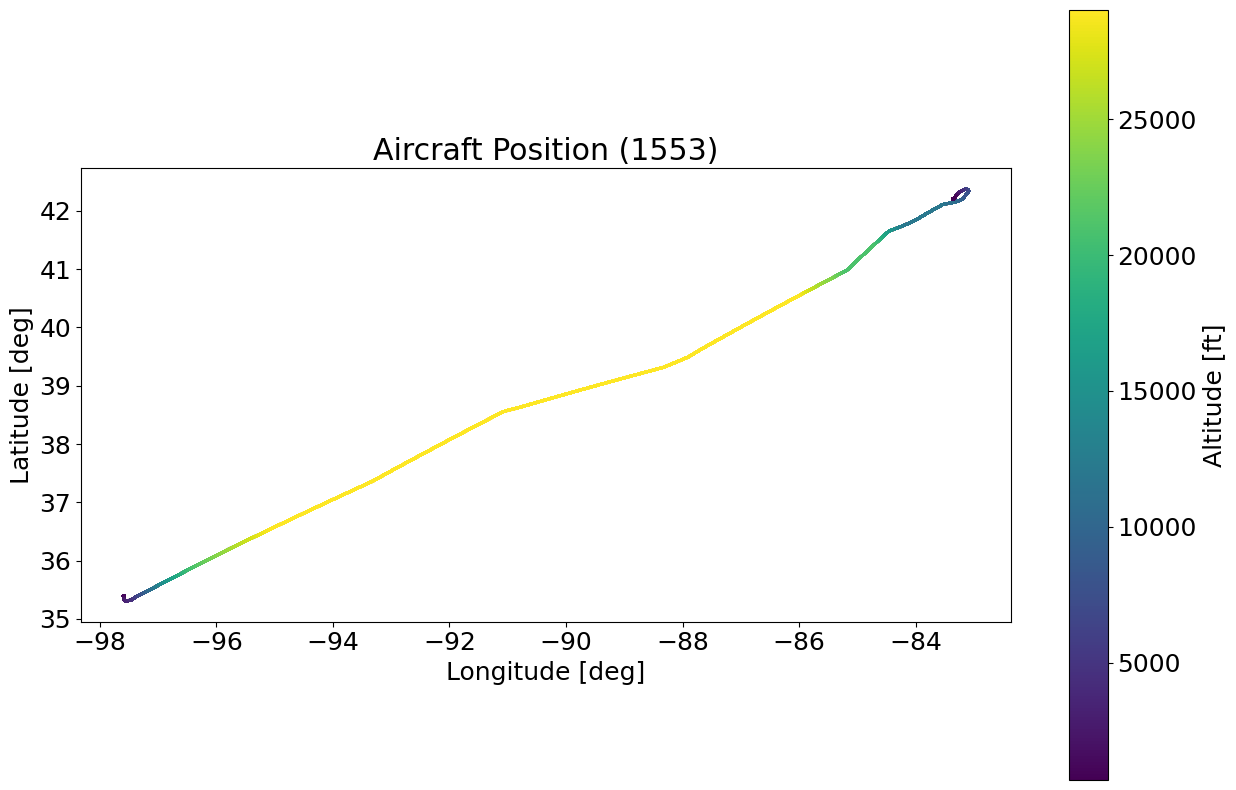

In [17]:
# Filter out invalid lat/long/altitude measurements
where_valid = df_1553[df_1553["NAV-0110"] & df_1553["NAV-0111"]]
plt.rcParams.update({"font.size":18})

# plot
fig, ax = plt.subplots()
ax = where_valid.plot(
    kind="scatter", title="Aircraft Position (1553)",
    x="NAV-23", y="NAV-21", c="NAV-25", s=1,
    cmap="viridis", figsize=(15, 10), ax=ax)

ax.set_aspect("equal")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
plt.gcf().get_axes()[1].set_ylabel("Altitude [ft]")
plt.show()

### Reset TIP example.

In [18]:
index_1 = small_index[small_index.label == 'tail_35_pilot_slider_1']

parsed_path = index_1[index_1.basket_type == 'ch10_parsed'].address.iloc[0]
s3.rm(parsed_path,recursive = True)
arinc_path = index_1[index_1.basket_type == 'ch10_translated_ARINC429'].address.iloc[0]
s3.rm(arinc_path,recursive = True)
milstd1553_path = index_1[index_1.basket_type == 'ch10_translated_MILSTD1553'].address.iloc[0]
s3.rm(milstd1553_path,recursive = True)

In [19]:
small_index = create_index_from_s3('provenance-demo')
small_index

,uuid,upload_time,parent_uuids,basket_type,label,address,storage_type
0,540f6386e51f11edb7020242ac12000a,04/27/2023 17:17:03,[],NASA_ARINC429_DTS,,provenance-demo/NASA_ARINC429_DTS/540f6386e51f...,s3
1,5ad74a12e51f11edb7020242ac12000a,04/27/2023 17:17:14,[],NASA_MILSTD1553_DTS,,provenance-demo/NASA_MILSTD1553_DTS/5ad74a12e5...,s3
2,224076e4e52211edb7020242ac12000a,04/27/2023 17:37:08,[],ch10,tail_35_pilot_slider_1,provenance-demo/ch10/224076e4e52211edb7020242a...,s3
